In [1]:
%matplotlib inline
%reload_ext Cython
font = {'family' : 'sans-serif',
        'style': 'normal',
        'weight' : 'medium',
        'size' : 38}
import matplotlib
matplotlib.rc('font', **font)
from __future__ import print_function
import time
import pylab
import numpy as np
from numpy import int16, uint16, uint8, float16, log2

import cv2
from cv2 import cvtColor as convertColor, COLOR_BGR2GRAY, COLOR_GRAY2RGB,\
                resize, imread, imwrite

try:                  #nearest neighboor interpolation
  from cv2.cv import CV_INTER_NN, \
                     CV_CAP_PROP_FRAME_WIDTH, \
                     CV_CAP_PROP_FRAME_HEIGHT, \
                     CV_CAP_PROP_FPS, \
                     CV_LOAD_IMAGE_GRAYSCALE
except:
  from cv2 import INTER_NEAREST as CV_INTER_NN, \
                  CAP_PROP_FRAME_WIDTH as CV_CAP_PROP_FRAME_WIDTH, \
                  CAP_PROP_FRAME_HEIGHT as CV_CAP_PROP_FRAME_HEIGHT, \
                  CAP_PROP_FPS as CV_CAP_PROP_FPS, \
                  IMREAD_GRAYSCALE as CV_LOAD_IMAGE_GRAYSCALE

import inspect
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import pyximport; pyximport.install()
#from pydvs.generate_spikes import *
from pydvs.generate_spikes import *


def range_image(width, height, max_val):
    num_pix = width*height
    
    img = [int(i*(float(max_val)/num_pix)) for i in range(num_pix)]
    
    return np.array(img, dtype=int16).reshape((height, width))

def plot(spike_lists, dt, num_neurons, markersize=5):
    tpos = []
    tneg = []
    pos = []
    neg = []
    t_count = 0
    for spk_list in spike_lists:
        for spk in spk_list:
            if spk < num_neurons:
                pos.append(spk)
                tpos.append(t_count)
            else:
                neg.append(spk)
                tneg.append(t_count)
    
        t_count += dt
    t_max_neg = 0 if len(tneg) == 0 else np.max(tneg)
    t_max_pos = 0 if len(tpos) == 0 else np.max(tpos)
    t_max = max(t_max_neg, t_max_pos)
    axes = pylab.gca()
    axes.set_xlim([0, t_count + 1])
    #axes.set_xlim([0, t_max + 1])
    axes.set_ylim([-1, num_neurons*2 + 1])
    pylab.plot(tneg, neg, '.r', markersize=markersize, markeredgewidth=0)
    pylab.plot(tpos, pos, '.b', markersize=markersize, markeredgewidth=0)


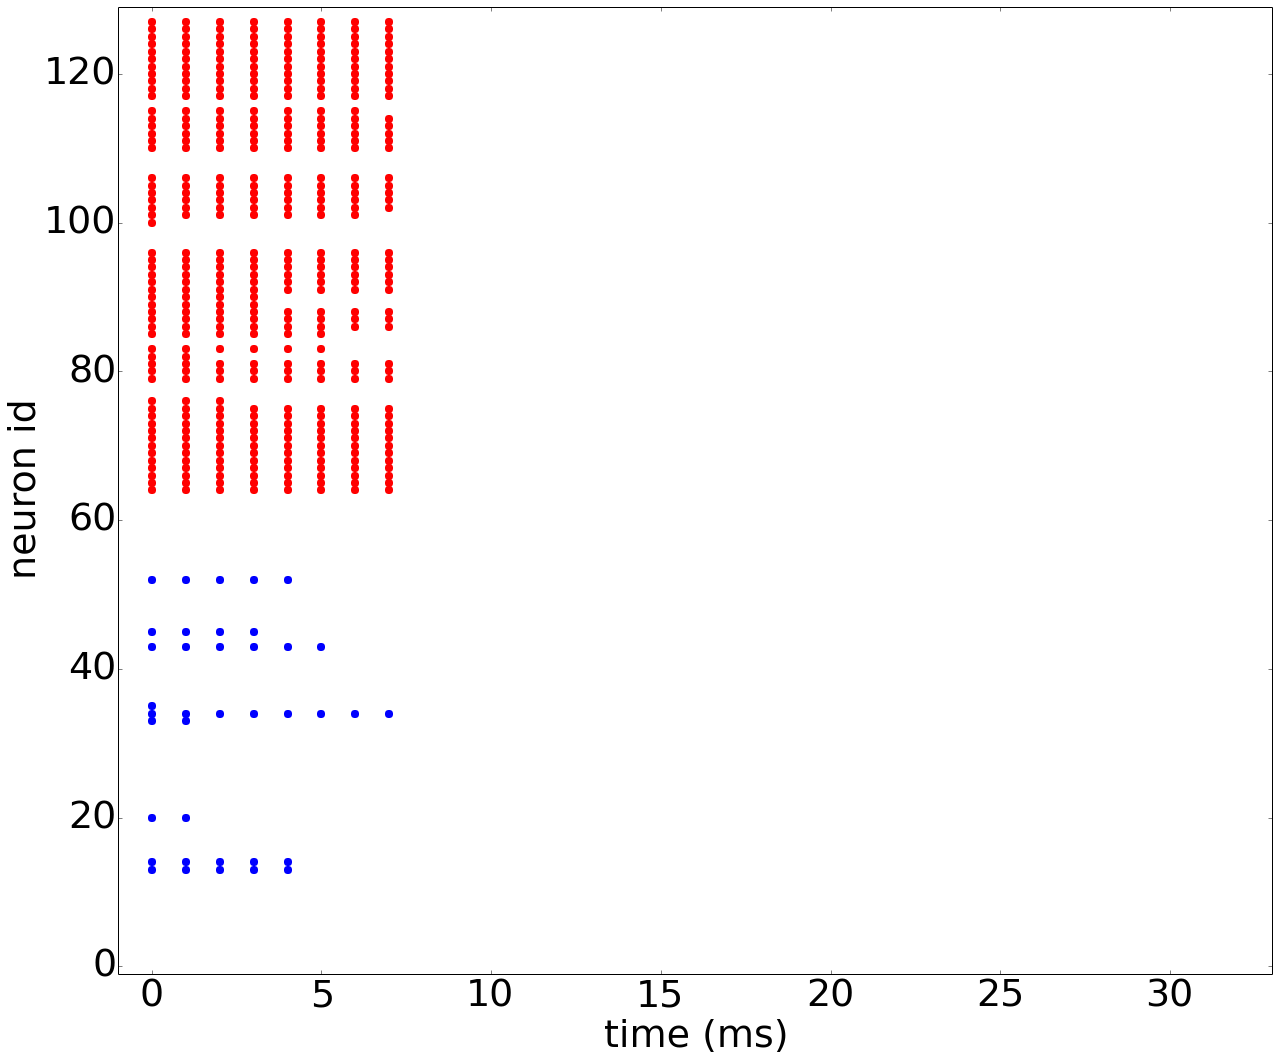

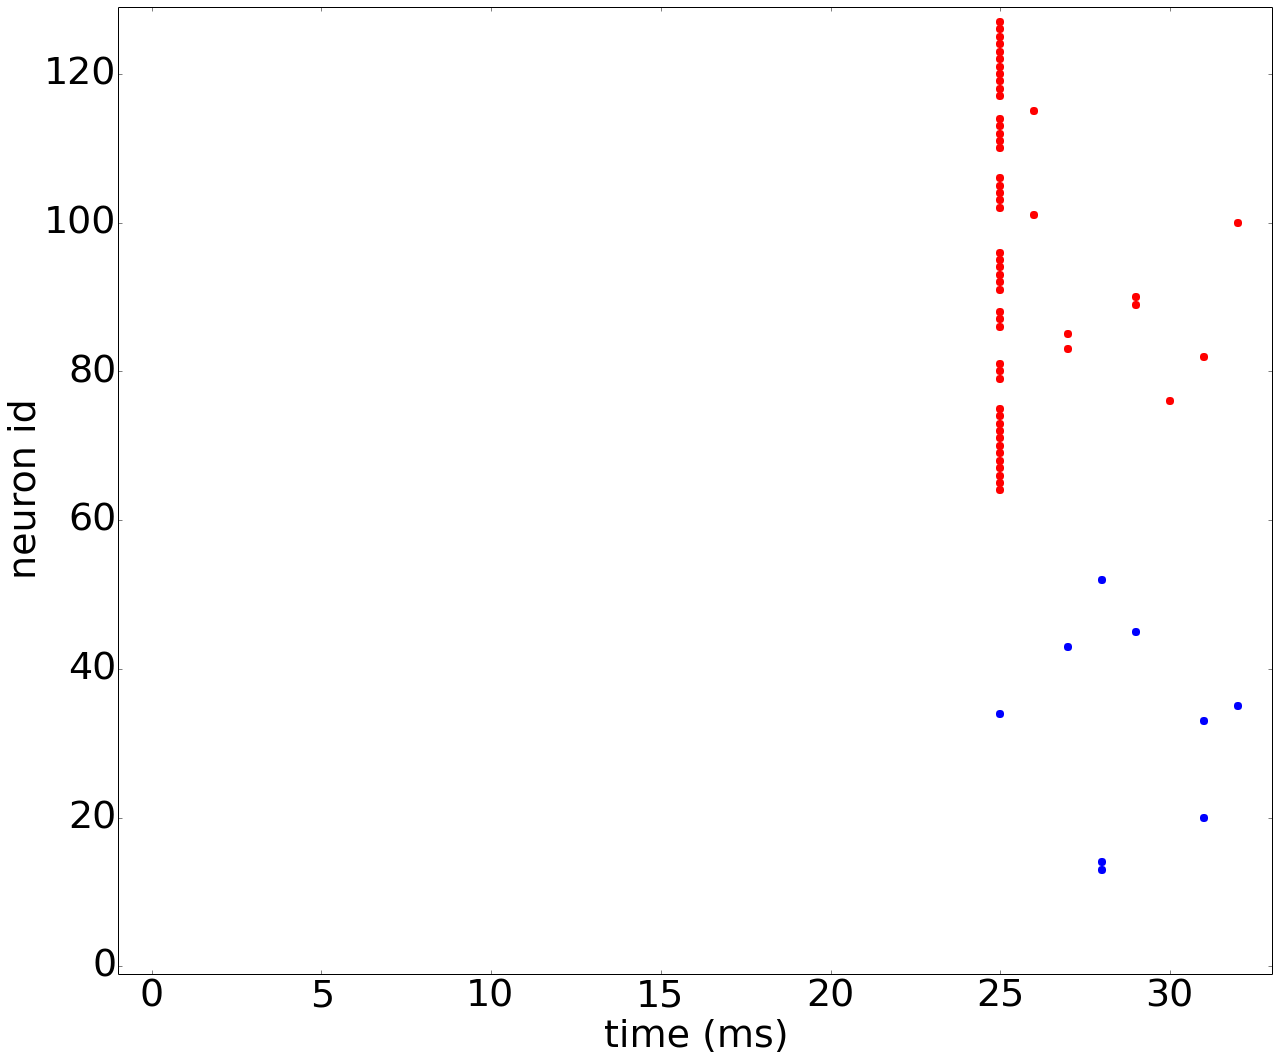

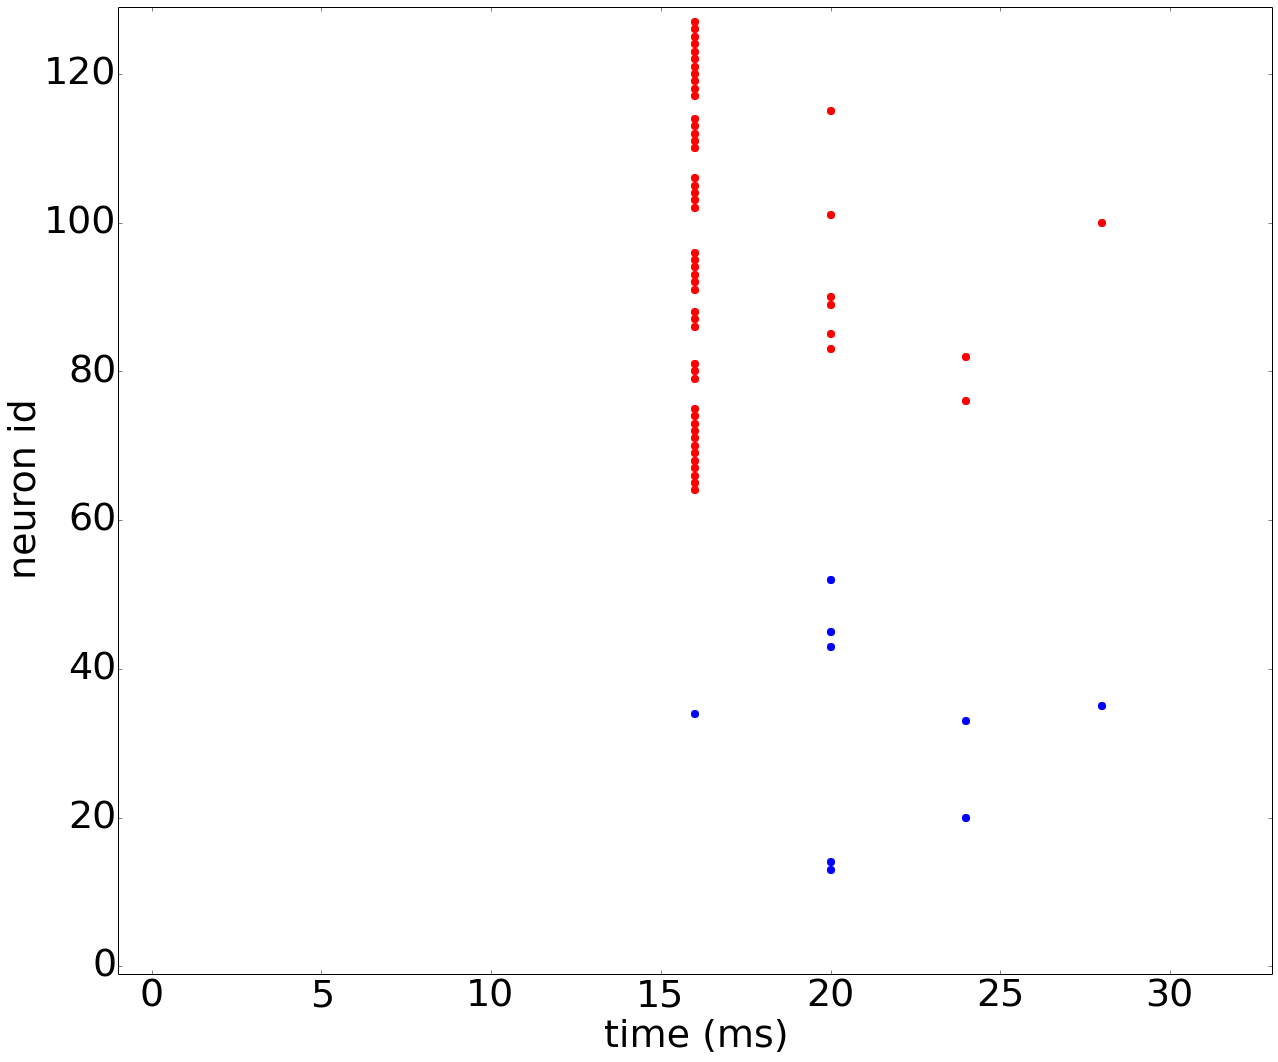

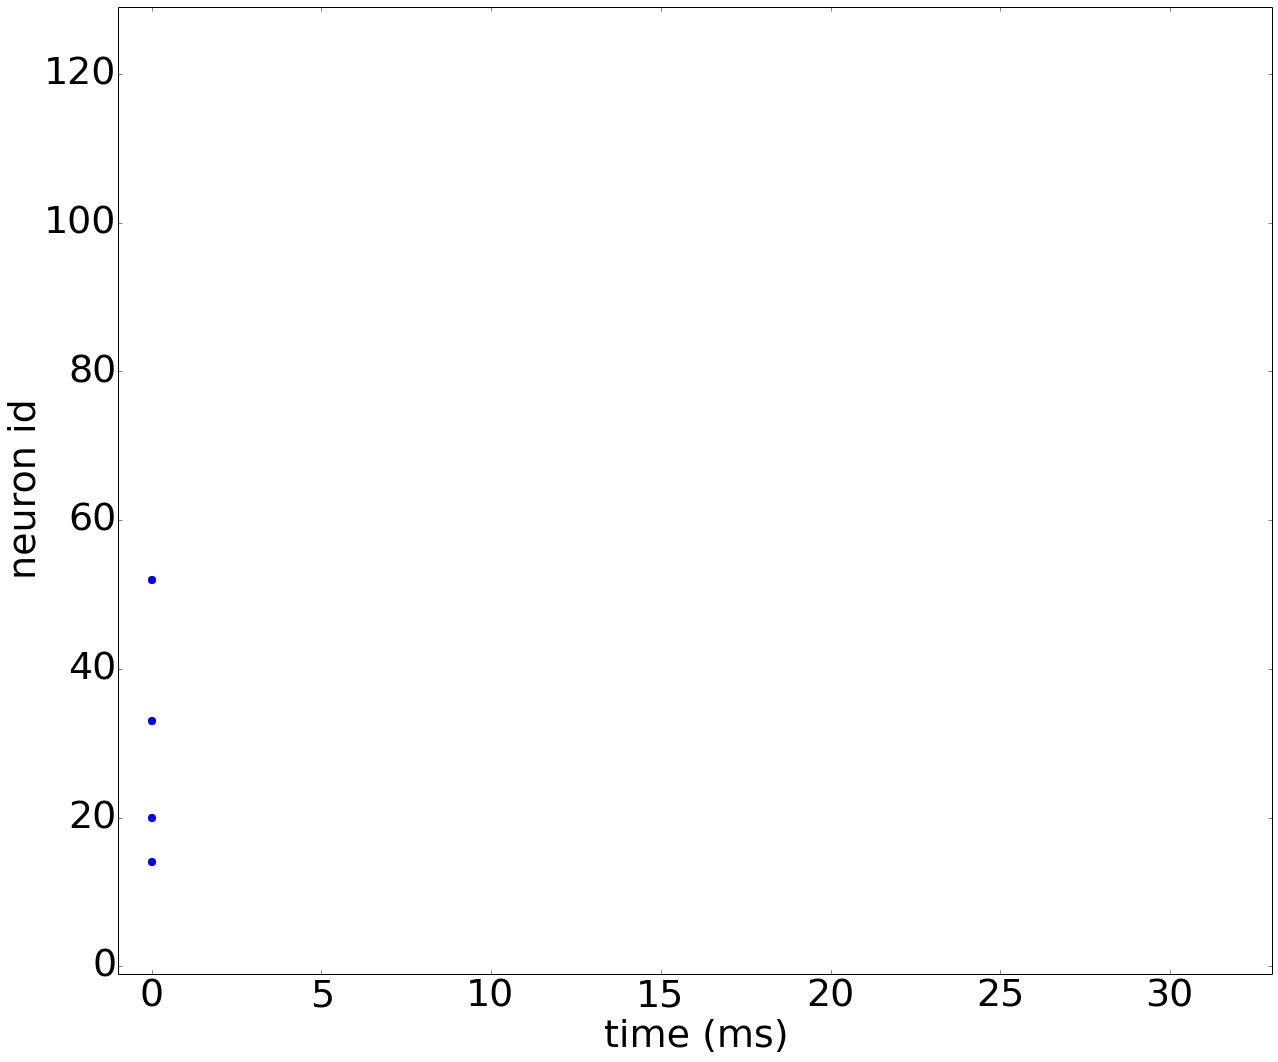

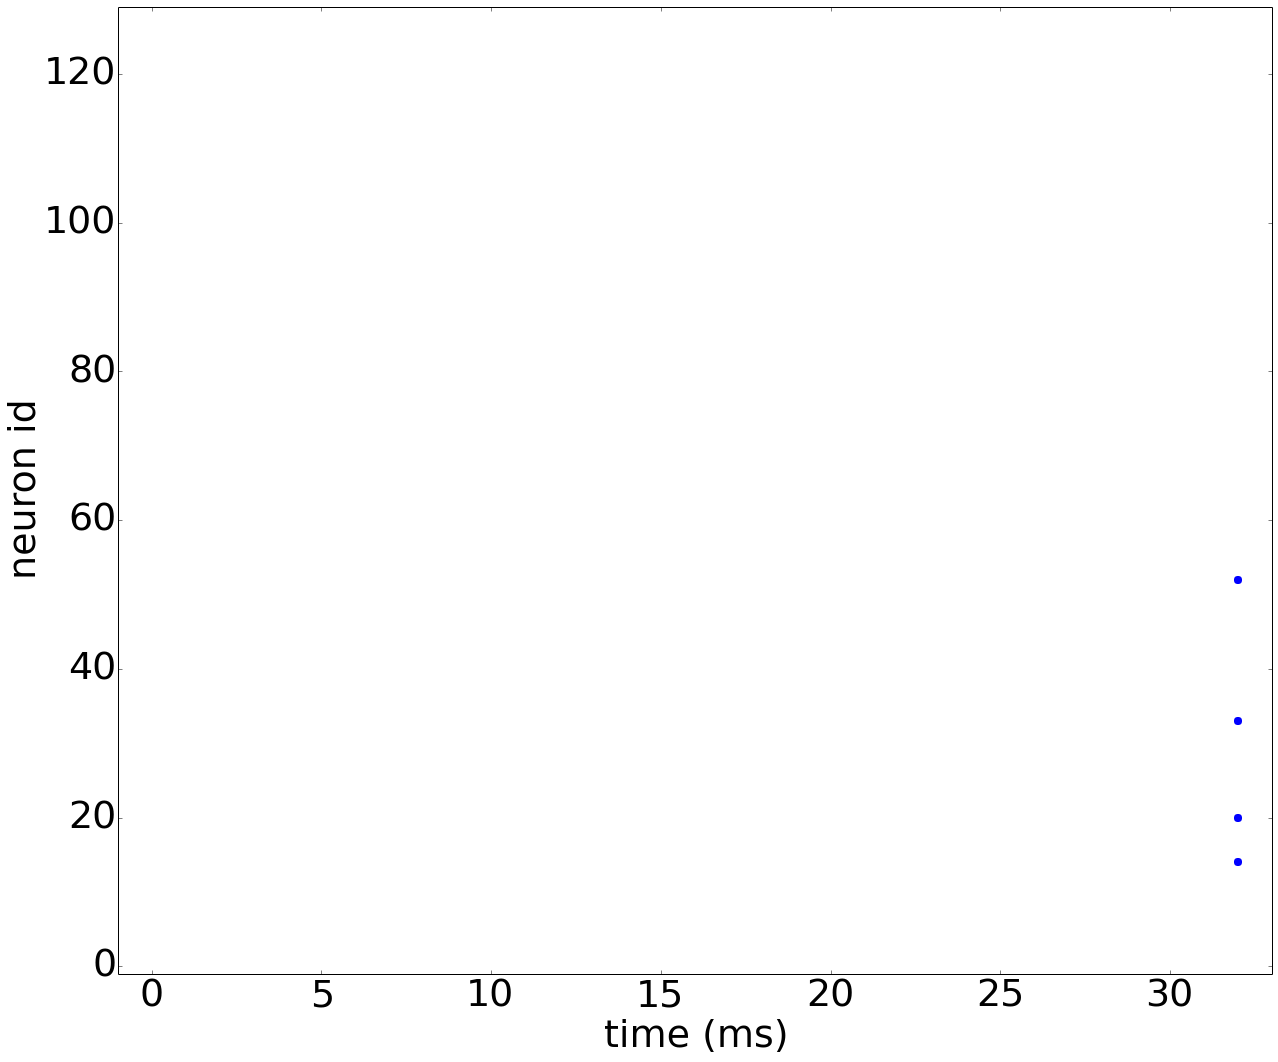

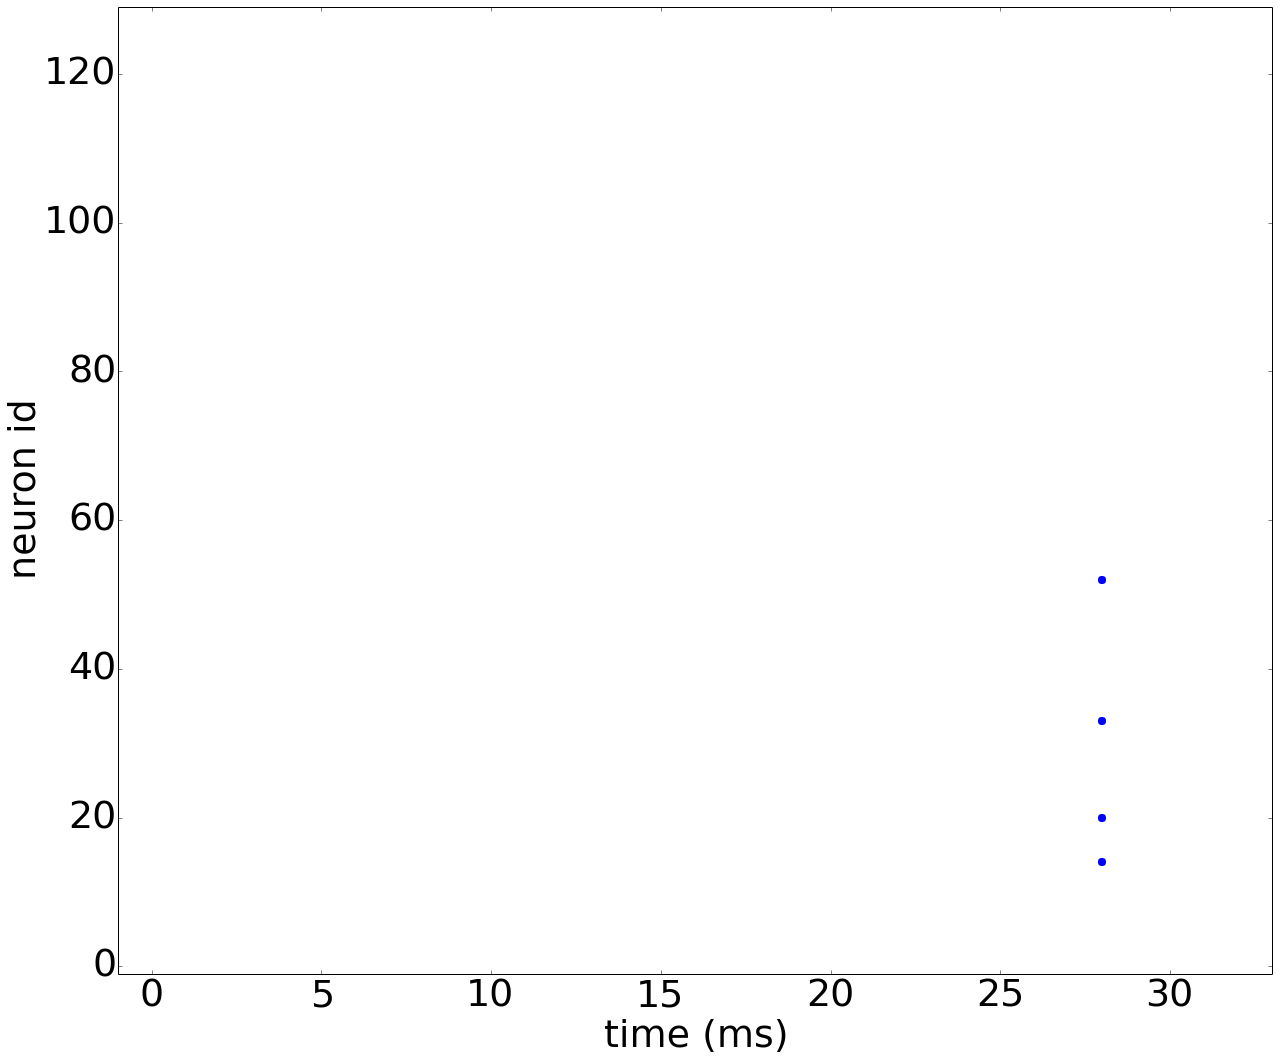

In [4]:
img_path = "./t10k-images-idx3-ubyte__idx_008__lbl_5_.png"


num_bits = 8   # how many bits are used to represent exceeded thresholds
num_active_bits = 1 # how many of bits are active
log2_table = generate_log2_table(num_active_bits, num_bits)[num_active_bits - 1]

UP_POLARITY    = 0
DOWN_POLARITY  = 1
MERGED_POLARITY = 2
RECTIFIED_POLARITY = 3

orig_w = 28
cam_w = 8
num_neurons = cam_w*cam_w
num_cycles = 3
history_weight = 0.95
cam_fps = 30
frame_time_ms = int(1000./cam_fps)
data_shift = uint8(np.log2(cam_w))
flag_shift = uint8(2*data_shift)
data_mask  = uint8(cam_w - 1)
noise_probability = 10 # per-cent

orig_img = np.zeros((orig_w, orig_w), dtype=int16)
padd_img = np.zeros((cam_w, cam_w), dtype=int16)
send_ref = 127*np.ones((cam_w, cam_w), dtype=int16)
recv_ref = 127*np.ones((cam_w, cam_w), dtype=int16)
curr = np.zeros((cam_w, cam_w), dtype=int16)
diff = np.zeros((cam_w, cam_w), dtype=int16)
abs_diff = np.zeros((cam_w, cam_w), dtype=int16)
spikes = np.zeros((cam_w, cam_w), dtype=int16)
spk_img = np.zeros((cam_w, cam_w, 3), dtype=uint8)
thresh = int( (2**8 - 1)*0.06 )
frm = (cam_w - orig_w)/2.
to  = frm + orig_w
show_every_n_cycle = 5
snd_rcv_diff =  np.zeros((cam_w, cam_w), dtype=int16)

orig_img[:] = imread(img_path, CV_LOAD_IMAGE_GRAYSCALE)
curr[:] = resize(orig_img, (cam_w, cam_w))
# curr[:] = range_image(width, height, max_val)
base_name = "spike_coding_test___cycle_%03d___%s.png"
markersize = 16
max_x = int(frame_time_ms)
figsize = (18, 15)
for i in range(num_cycles):
    
    diff[:], abs_diff[:], spikes[:] = thresholded_difference(curr, send_ref, thresh)
    send_ref[:] = update_reference_time_thresh(abs_diff, spikes, send_ref,
                                               thresh,
                                               frame_time_ms,
                                               history_weight)
    if i == 0:
        recv_ref[:] = update_reference_time_thresh_noise(abs_diff, spikes, recv_ref,
                                                         cam_w, cam_w,
                                                         thresh,
                                                         frame_time_ms,
                                                         history_weight,
                                                         noise_probability)
    else:
        recv_ref[:] = update_reference_time_thresh(abs_diff, spikes, recv_ref,
                                                   thresh,
                                                   frame_time_ms,
                                                   history_weight)
    neg, pos, gmax = split_spikes(spikes, abs_diff, MERGED_POLARITY)

    spikes_rate = make_spike_lists_rate(pos, neg, gmax,
                                        thresh,
                                        flag_shift, data_shift, data_mask,
                                        frame_time_ms)
                                        
    spikes_time = make_spike_lists_time(pos, neg, gmax,
                                        flag_shift, data_shift, data_mask,
                                        frame_time_ms,
                                        frame_time_ms,
                                        thresh,
                                        thresh)

    
    spikes_exp = make_spike_lists_time_bin_thr(pos, neg, gmax,
                                               flag_shift, data_shift, data_mask,
                                               frame_time_ms,
                                               thresh,
                                               thresh,
                                               num_bits,
                                               log2_table)
    
    
    spk_img[:] = render_frame(spikes, curr, cam_w, cam_w, MERGED_POLARITY)
    
    
    if (i+1)%show_every_n_cycle == 0 or \
       i == 0 or i == 1:
        fig = pylab.figure(figsize=figsize,dpi=300)
        ax = fig.add_subplot(1,1,1)
        pylab.xlabel('time (ms)')
        pylab.ylabel('neuron id')
        plot(spikes_rate, dt=1, num_neurons=num_neurons, markersize=markersize)
        pylab.xlim(-1, max_x)

        pylab.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        fig.savefig("%s_coded_-%dx%d-_cycle_%s.png"%("rate", cam_w, cam_w, i))
        pylab.show()

        fig = pylab.figure(figsize=figsize,dpi=300)
        ax = fig.add_subplot(1,1,1)
        pylab.xlabel('time (ms)')
        pylab.ylabel('neuron id')
        plot(spikes_time, dt=1, num_neurons=num_neurons, markersize=markersize)
        pylab.xlim(-1, max_x)

        pylab.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        fig.savefig("%s_coded_-%dx%d-_cycle_%s.png"%("time", cam_w, cam_w, i))
        pylab.show()

        fig = pylab.figure(figsize=figsize,dpi=300)
        ax = fig.add_subplot(1,1,1)
#        for tick in ax.xaxis.get_major_ticks():
#                tick.label.set_fontsize(16) 
#        for tick in ax.yaxis.get_major_ticks():
#                tick.label.set_fontsize(16) 
        pylab.xlabel('time (ms)')
        pylab.ylabel('neuron id')
        plot(spikes_exp, dt=int(frame_time_ms/num_bits), num_neurons=num_neurons, 
             markersize=markersize)
        pylab.xlim(-1, max_x)

        pylab.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

        fig.savefig("%s_coded_-%dx%d-_cycle_%s.png"%("time_exp", cam_w, cam_w, i))
        pylab.show()